In [1]:
%reload_ext autoreload
%autoreload 2

# Import everything
from logging import getLogger, basicConfig, INFO, WARNING
from json import load
from telegram import Update
from telegram.ext import Updater, CommandHandler, CallbackContext, MessageHandler, Filters
from time import sleep
from library.AMI135 import AMI135
from library.LevelMeter import LevelMeter
from library.HeliumLogger import HeliumLogger
from library.arg_handler import plot_arg_handler_scheer_2
from library.plotter import generate_plot_scheer_2
from library.arg_handler import notifications_arg_handler
from library.Notifications import Notifications

# Configurate Logger
logger = getLogger('HeliumBot')
basicConfig(filename='_logging_output.txt',
            filemode='a',
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
            level=INFO)
getLogger('apscheduler.scheduler').setLevel(WARNING)

class HeliumBot:
    def __init__(
            self,
            dewar = 'Scheer 2',
    ):        
        # All possible configs
        with open('HeliumBot_config.json') as f:
            self.all_config = load(f)
        
        # Get Config for Dewar
        self.config = self.all_config[dewar]

        self.name = "HeliumBot"
        # Initialize Driver, LevelMeter(Driver), HeliumLogger(LevelMeter)
        self.driver = eval(self.config['driver']['name'])()
        self.levelmeter = LevelMeter(driver=self.driver,
                                     refresh_rate=self.config['driver']['refresh_rate'])
        self.heliumlogger = HeliumLogger(levelmeter=self.levelmeter,
                                         config=self.config['logger'])

        # Initialize Telegram Bot
        self.telegram_bot = f"TelegramBot@{self.config['telegram']['bot_name']}"
        self.updater = Updater(token=self.config['telegram']['token'], use_context=True)
        self.dispatcher = self.updater.dispatcher
        self.all_commands={'help':['help','hlep']}
        logger.info(f"({self.telegram_bot}) ... initialized!)")

        # Initialize Notifications(LevelMeter, Updater)
        self.notifications = Notifications(levelmeter=self.levelmeter,
                                           updater=self.updater)
        # Initialize Handlers
        self.add_handlers()
        
        sleep(3)
        logger.info(f"({self.name}) ... initialized!")
    
    def init(self):
        self.levelmeter.init()
        self.heliumlogger.init()
        self.updater.start_polling()
        logger.info(f"(TelegramBotWorker@{self.config['telegram']['bot_name']}) ... initialized!)")
        logger.info(f"(TelegramBotWorker@{self.config['telegram']['bot_name']}) ... started running!)")
        logger.info(f"({self.telegram_bot}) Worker is started.)")
        logger.info(f"({self.name}) ... started running!")
    
    def close(self):
        self.heliumlogger.close()
        self.notifications.close_all()
        self.updater.stop()
        logger.info(f"(TelegramBotWorker@{self.config['telegram']['bot_name']}) ... stopped running!)")
        logger.info(f"({self.telegram_bot}) Worker is stopped.)")
        logger.info(f"({self.name}) ... stopped running!")

        
    def add_handlers(self):
        # Status Handler
        def get_status(update: Update, context: CallbackContext):
            chat_id = update.effective_chat.id
            printer = self.levelmeter.status['printer']
            context.bot.send_message(chat_id=chat_id,
                                     text=f"{printer}")
            logger.info(f"({self.telegram_bot}@{chat_id}) sent: {printer}")
        items = ['helium','status']
        for item in items:
            self.dispatcher.add_handler(CommandHandler(item, get_status))
        self.all_commands['status'] = items
        
        # Notification Handler
        def get_notifications(update: Update, context: CallbackContext):
            chat_id = update.effective_chat.id        
            text = ' '.join(context.args)
            args, description = notifications_arg_handler(text) 
            if text=='':
                context.bot.send_message(chat_id=update.effective_chat.id,
                                         text=description)    
            if args['notifications'] is not None:
                self.notifications.set_notifications(chat_id=chat_id,
                                                     value=args['notifications'])
            if args['alarm'] is not None:
                self.notifications.set_alarm(chat_id=chat_id,
                                             value=args['alarm'])
            if args['refresh_rate'] is not None:
                self.notifications.set_refresh_rate(chat_id=chat_id,
                                               value = args['refresh_rate'])
            if args['level'] is not None:
                self.notifications.set_alarm_level(chat_id=chat_id,
                                                   value = args['level'])
            string = str(self.notifications.get_status(chat_id=chat_id))
            context.bot.send_message(chat_id=update.effective_chat.id,
                                     text=string)
            logger.info(f"({self.telegram_bot}@{chat_id}) {string}")

        items = ['notify','notifications','notification']
        for item in items:
            self.dispatcher.add_handler(CommandHandler(item, get_notifications))
        self.all_commands['notifications'] = items
        
        def get_plot(update: Update, context: CallbackContext):
            chat_id = update.message.chat_id
            text = ' '.join(context.args)
            args, description = eval(self.config['plotter']['arg_handler'])(text)  
            if text=='':
                context.bot.send_message(chat_id=update.effective_chat.id,
                                         text=description)         
            file_name, caption = eval(self.config['plotter']['function'])(args, self.config)
            context.bot.sendPhoto(chat_id=chat_id,
                                 photo=open(file_name, 'rb'),
                                 disable_notification = True,
                                 caption = caption)
            logger.info(f"({self.telegram_bot}@{chat_id}) {caption}")
        items = ['plot', 'plt', 'graph', 'curve']
        for item in items:
            self.dispatcher.add_handler(CommandHandler(item, get_plot))
        self.all_commands['plot'] = items
        
        # Help Handler
        def helper(update: Update, context: CallbackContext):
            chat_id=update.effective_chat.id
            description=''
            for k in self.all_commands.keys():
                string=''
                for s in self.all_commands[k]:
                    string=string+f", /{s}"
                description = description +f"{k}: {string[2:]}\n"
            text=f"Use one of the following commands, for\n"+description
            context.bot.send_message(chat_id=chat_id,
                                     text=text)
            logger.info(f"({self.telegram_bot}@{chat_id}) ... sent help.")
        for item in self.all_commands['help']:
            self.dispatcher.add_handler(CommandHandler(item, helper))

        # Unknown Handler (must be the last Handler added)
        def unknown(update: Update, context: CallbackContext):
            context.bot.send_message(chat_id=update.effective_chat.id,
                                     text="Sorry, I didn't understand that command. Use /help for help.")
        unknown_handler = MessageHandler(Filters.text | Filters.command, unknown)
        self.dispatcher.add_handler(unknown_handler)

        
heliumbot = HeliumBot()
heliumbot.init()

In [5]:
import numpy as np
np.random.rand(1)[0]

0.7716216908299265

In [6]:
from library.TestDriver import TestDriver

In [7]:
testdriver = TestDriver()

In [8]:
testdriver.status

{'file_string': '2022-04-15 08:00:33, 57.4493837787367, 26.049901270718163, 24.09138588322709',
 'printer': '2022-04-15 08:00:33, 57.4493837787367 cm, 26.05 L, 24.09 %',
 'volume': 26.049901270718163}

In [21]:
all_config = {
            'Scheer 2':{'name': 'Scheer 2',
                       'driver': {'name':'AMI135',
                                  'refresh_rate': 2},
                       'logger': {'path': 'helium_nu',
                                  'file_name': 'scheer2_helium',
                                  'refresh_rate':5,
                                  'header': ['with_IVC: True',
                                             'date [%Y-%m-%d %H:%M:%S], fill_height [cm], volume [L], percentage [%]']},
                       'telegram':{'token':'5204069100:AAFMzDK4WCR2vC4va8s3s6tpGvb1PzmEroU',
                                   'bot_name':'scheer_2_dewar_bot'},
                       'plotter': {'pattern':"[('date','datetime64[s]'),('fill_height','f8'),('volume','f8'),('percentage','f8')]",
                                   'max_days': 30,
                                   'function':'generate_plot_scheer_2',
                                   'arg_handler':'plot_arg_handler_scheer_2',
                                   'title': "'Scheer II' Dewar"},
                      },
                           }

In [14]:

with open('HeliumBot_config.json') as f:
    all_config = load(f)
print(type(all_config['Scheer 2']['plotter']['pattern']))

<class 'list'>


In [22]:
import numpy as np
np.array(0, dtype=eval(all_config['Scheer 2']['plotter']['pattern']))

array(('1970-01-01T00:00:00', 0., 0., 0.),
      dtype=[('date', '<M8[s]'), ('fill_height', '<f8'), ('volume', '<f8'), ('percentage', '<f8')])

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime

def get_data(config={'logger': {'path': 'helium_nu',
                                'file_name': 'scheer2_helium'},
                     'plotter': {'pattern':[('date','datetime64[s]'),('fill_height','f8'),
                                            ('volume','f8'),('percentage','f8')],
                                 'max_days': 30}}):
    files = glob(f"{config['logger']['path']}\\{config['logger']['file_name']}_*.csv")[-config['plotter']['max_days']:]
    data = np.array([0], dtype=config['plotter']['pattern'])
    for file in files:
        dat = np.genfromtxt(file, comments='#', delimiter=",", dtype=config['plotter']['pattern'])
        data=np.concatenate((data, dat), axis=0)
    return data[1:]
str(get_data()['date'][-1]).replace('T',' ')

'2022-04-01 11:41:55'

In [3]:
heliumbot.notifications.set_notifications(62579439,{'notifications':True, 'refresh_rate':10})

2022-04-01 13:31:31,062 - telegram.ext.updater - ERROR - Error while getting Updates: Conflict: terminated by other getUpdates request; make sure that only one bot instance is running
2022-04-01 13:31:31,067 - telegram.ext.dispatcher - ERROR - No error handlers are registered, logging exception.
Traceback (most recent call last):
  File "C:\Users\VNA-Rechner\anaconda3\lib\site-packages\telegram\ext\updater.py", line 646, in _network_loop_retry
    if not action_cb():
  File "C:\Users\VNA-Rechner\anaconda3\lib\site-packages\telegram\ext\updater.py", line 597, in polling_action_cb
    updates = self.bot.get_updates(
  File "C:\Users\VNA-Rechner\anaconda3\lib\site-packages\telegram\ext\extbot.py", line 224, in get_updates
    updates = super().get_updates(
  File "C:\Users\VNA-Rechner\anaconda3\lib\site-packages\telegram\bot.py", line 130, in decorator
    result = func(*args, **kwargs)
  File "C:\Users\VNA-Rechner\anaconda3\lib\site-packages\telegram\bot.py", line 3054, in get_updates
  

In [4]:
heliumbot.close()

2022-04-01 13:31:33,055 - HeliumBot - INFO - (HeliumLogger) Worker is closed.
2022-04-01 13:31:33,163 - HeliumBot - INFO - (Notifications@62579439) Worker is closed.
2022-04-01 13:31:35,091 - telegram.ext.updater - ERROR - Error while getting Updates: Conflict: terminated by other getUpdates request; make sure that only one bot instance is running
2022-04-01 13:31:35,991 - HeliumBot - INFO - (HeliumLoggerWorker) ... stopped running!
2022-04-01 13:31:36,104 - HeliumBot - INFO - (TelegramBotWorker@scheer_2_dewar_bot) ... stopped running!)
2022-04-01 13:31:36,105 - HeliumBot - INFO - (TelegramBot@scheer_2_dewar_bot) Worker is stopped.)
2022-04-01 13:31:36,106 - HeliumBot - INFO - (HeliumBot) ... stopped running!
2022-04-01 13:31:36,349 - HeliumBot - INFO - (NotificationsWorker[62579439]) ... stopped running!


In [1]:

        

        
        
heliumbot.init()

2022-04-01 08:47:34,732 - root - INFO - (LevelMeter) ... initialized!
2022-04-01 08:47:34,734 - root - INFO - (HeliumLogger) ... initialized!
2022-04-01 08:47:34,736 - root - INFO - (Notifications) ... initialized!
2022-04-01 08:47:39,746 - root - INFO - (HeliumBot) ... initialized!
2022-04-01 08:47:39,746 - root - INFO - (LevelMeterWorker) ... initialized!
2022-04-01 08:47:39,746 - root - INFO - (LevelMeterWorker) ... started running!
2022-04-01 08:47:39,750 - root - INFO - (LevelMeter) Worker is started.
2022-04-01 08:47:39,751 - root - INFO - (HeliumLoggerWorker) ... initialized!
2022-04-01 08:47:39,752 - root - INFO - (HeliumLoggerWorker) ... started running!
2022-04-01 08:47:39,755 - root - INFO - (HeliumLogger) Worker is started.
2022-04-01 08:47:39,756 - apscheduler.scheduler - INFO - Scheduler started
Exception in thread HeliumLoggerWorker:
Traceback (most recent call last):
  File "C:\Users\VNA-Rechner\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
 

In [1]:
%reload_ext autoreload
%autoreload 2

# Import and configurate Logger
from logging import getLogger, basicConfig, INFO
logger = getLogger()    
basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                     level=INFO)

# Import Argument Handler and Plot Function
from plotter import generate_plot
from arg_handler import notifications_arg_handler, plot_arg_handler

# Import and initialize Driver
from AMI135 import AMI135
driver = AMI135()

# Import and initialize LevelMeter
from LevelMeter import LevelMeter
levelmeter = LevelMeter(driver=driver)

# Import and initialize HeliumLogger, with Driver as Input
from HeliumLogger import HeliumLogger
heliumlogger = HeliumLogger(levelmeter=levelmeter)

# Import and initialize Telegram Bot
from telegram import Update
from telegram.ext import Updater, CommandHandler, CallbackContext, MessageHandler, Filters
schmampfpy3_token = '1817796104:AAE-PugEYnIUzDh4tR1hjz86cfs9Ooz_gLc'
scheer_2_dewar_bot = '5204069100:AAFMzDK4WCR2vC4va8s3s6tpGvb1PzmEroU'
updater = Updater(token=scheer_2_dewar_bot, use_context=True)
dispatcher = updater.dispatcher
telegram_bot = "TelegramBot"
all_commands={'help':['help','hlep']}

# Import and initialize Notifications
from Notifications import Notifications
notifications = Notifications(levelmeter=levelmeter, updater=updater)

2022-03-31 20:11:36,015 - root - INFO - (AMI135) ... initialized!
2022-03-31 20:11:36,024 - root - INFO - (LevelMeter) ... initialized!
2022-03-31 20:11:36,030 - root - INFO - (HeliumLogger) ... initialized!
2022-03-31 20:11:36,300 - root - INFO - (Notifications) ... initialized!


In [2]:
def get_status(update: Update, context: CallbackContext):
    chat_id = update.effective_chat.id
    printer = levelmeter.status['printer']
    context.bot.send_message(chat_id=chat_id,
                             text=f"{printer}")
    logger.info(f"({telegram_bot}@{chat_id}) sent: {printer}")
    
items = ['helium','status']
for item in items:
    dispatcher.add_handler(CommandHandler(item, get_status))
all_commands['status'] = items

In [3]:
def get_notifications(update: Update, context: CallbackContext):
    chat_id = update.effective_chat.id        
    text = ' '.join(context.args)
    args, description = notifications_arg_handler(text) 
    if text=='':
        context.bot.send_message(chat_id=update.effective_chat.id,
                                 text=description)    
    if args['notifications'] is not None:
        notifications.set_notifications(chat_id=chat_id,
                                        value=args['notifications'])
    if args['alarm'] is not None:
        notifications.set_alarm(chat_id=chat_id,
                                value=args['alarm'])
    if args['refresh_rate'] is not None:
        notifications.set_refresh_rate(chat_id=chat_id,
                                       value = args['refresh_rate'])
    if args['level'] is not None:
        notifications.set_alarm_level(chat_id=chat_id,
                                      value = args['level'])
    string = str(notifications.get_status(chat_id=chat_id))
    context.bot.send_message(chat_id=update.effective_chat.id,
                             text=string)
    logger.info(f"({telegram_bot}@{chat_id}) {string}")
    
items = ['notify','notifications','notification']
for item in items:
    dispatcher.add_handler(CommandHandler(item, get_notifications))
all_commands['notifications'] = items

In [4]:
from matplotlib.pyplot import close as pltclose
def get_plot(update: Update, context: CallbackContext):
    chat_id = update.message.chat_id
    text = ' '.join(context.args)
    args, description = plot_arg_handler(text)  
    if text=='':
        context.bot.send_message(chat_id=update.effective_chat.id,
                                 text=description)         
    file_name, caption = generate_plot(args)
    pltclose('all')
    context.bot.sendPhoto(chat_id=chat_id,
                         photo=open(file_name, 'rb'),
                         disable_notification = True,
                         caption = caption)
    logger.info(f"({telegram_bot}@{chat_id}) {caption}")
    
items = ['plot', 'plt', 'graph', 'curve']
for item in items:
    dispatcher.add_handler(CommandHandler(item, get_plot))
all_commands['plot'] = items

In [5]:
def helper(update: Update, context: CallbackContext):
    chat_id=update.effective_chat.id
    description=''
    for k in all_commands.keys():
        string=''
        for s in all_commands[k]:
            string=string+f", /{s}"
        description = description +f"{k}: {string[2:]}\n"
    text=f"Use one of the following commands, for\n"+description
    context.bot.send_message(chat_id=chat_id,
                             text=text)
    logger.info(f"({telegram_bot}@{chat_id}) ... sent help.")
    
for item in all_commands['help']:
    dispatcher.add_handler(CommandHandler(item, helper))

def unknown(update: Update, context: CallbackContext):
    context.bot.send_message(chat_id=update.effective_chat.id,
                             text="Sorry, I didn't understand that command. Use /help for help.")

unknown_handler = MessageHandler(Filters.text | Filters.command, unknown)
dispatcher.add_handler(unknown_handler)

2022-03-31 20:11:41,133 - root - INFO - (LevelMeterWorker) ... initialized!
2022-03-31 20:11:41,134 - root - INFO - (LevelMeterWorker) ... started running!
2022-03-31 20:11:41,137 - root - INFO - (LevelMeter) Worker is started.
2022-03-31 20:11:41,139 - root - INFO - (HeliumLoggerWorker) ... initialized!
2022-03-31 20:11:41,140 - root - INFO - (HeliumLoggerWorker) ... started running!
2022-03-31 20:11:41,142 - root - INFO - (HeliumLogger) Worker is started.
2022-03-31 20:11:41,143 - apscheduler.scheduler - INFO - Scheduler started


2022-03-31 20:12:54,257 - root - INFO - (NotificationsWorker[62579439]) ... initialized!
2022-03-31 20:12:54,267 - root - INFO - (NotificationsWorker[62579439]) ... started running!
2022-03-31 20:12:54,272 - root - INFO - (Notifications@62579439) Worker is started.
2022-03-31 20:12:54,397 - root - INFO - (NotificationsWorker[62579439]) 2022-03-31 18:12:53, 116.8 cm, 76.32 L, 96.61 %
2022-03-31 20:12:56,164 - root - INFO - (TelegramBot@62579439) {'chat_id': 62579439, 'notifications': True, 'alarm': False, 'refresh_rate': 7200.0, 'level': 20.0, 'program_refresh': 10}
2022-03-31 20:13:10,297 - root - INFO - (TelegramBot@62579439) {'chat_id': 62579439, 'notifications': True, 'alarm': False, 'refresh_rate': 7200.0, 'level': 20.0, 'program_refresh': 10}
2022-03-31 20:14:27,236 - root - INFO - (TelegramBot@62579439) {'chat_id': 62579439, 'notifications': True, 'alarm': False, 'refresh_rate': 7200.0, 'level': 20.0, 'program_refresh': 10}
2022-03-31 20:14:40,320 - root - INFO - (TelegramBot@625

In [7]:
notifications.status, notifications.threads

([], ([], {}))

In [8]:
heliumlogger.close()
updater.stop()
notifications.close_all()

2022-03-31 13:43:38,403 - root - INFO - (HeliumLogger) Worker is closed.
2022-03-31 13:43:38,406 - apscheduler.scheduler - INFO - Scheduler has been shut down
2022-03-31 13:43:39,584 - root - INFO - (HeliumLoggerWorker) ... stopped running!


In [3]:
from datetime import datetime
from os.path import isfile
from csv import reader
path='helium'
file_name='helium_'
utc_timer = datetime.utcnow()
import numpy as np


file = f"{path}\\{file_name}_{utc_timer.strftime('%Y-%m-%d')}.csv"
print(file)

initialized = False
if isfile(file):
    print('yes')
    i=0
    with open(file, 'r', encoding='utf8') as f:
        print(f)
        i=i+1
        print(i, np.genfromtxt(f))
        first_line = f.readline()
        print(str(first_line))
        print(str(first_line) == '')
        print(str(first_line) == '# ')
        #initialized = (str(next(reader(f)))[2:12] == "# with_IVC")

helium\helium__2022-04-01.csv


['helium\\helium__2022-03-24.csv', 'helium\\helium__2022-03-25.csv', 'helium\\helium__2022-03-26.csv', 'helium\\helium__2022-03-27.csv', 'helium\\helium__2022-03-28 (2).csv', 'helium\\helium__2022-03-28.csv', 'helium\\helium__2022-03-29.csv', 'helium\\helium__2022-03-30.csv', 'helium\\helium__2022-03-31.csv']


('._temp.png', 'plot generated at 2022-03-31 18:08:45.359460')

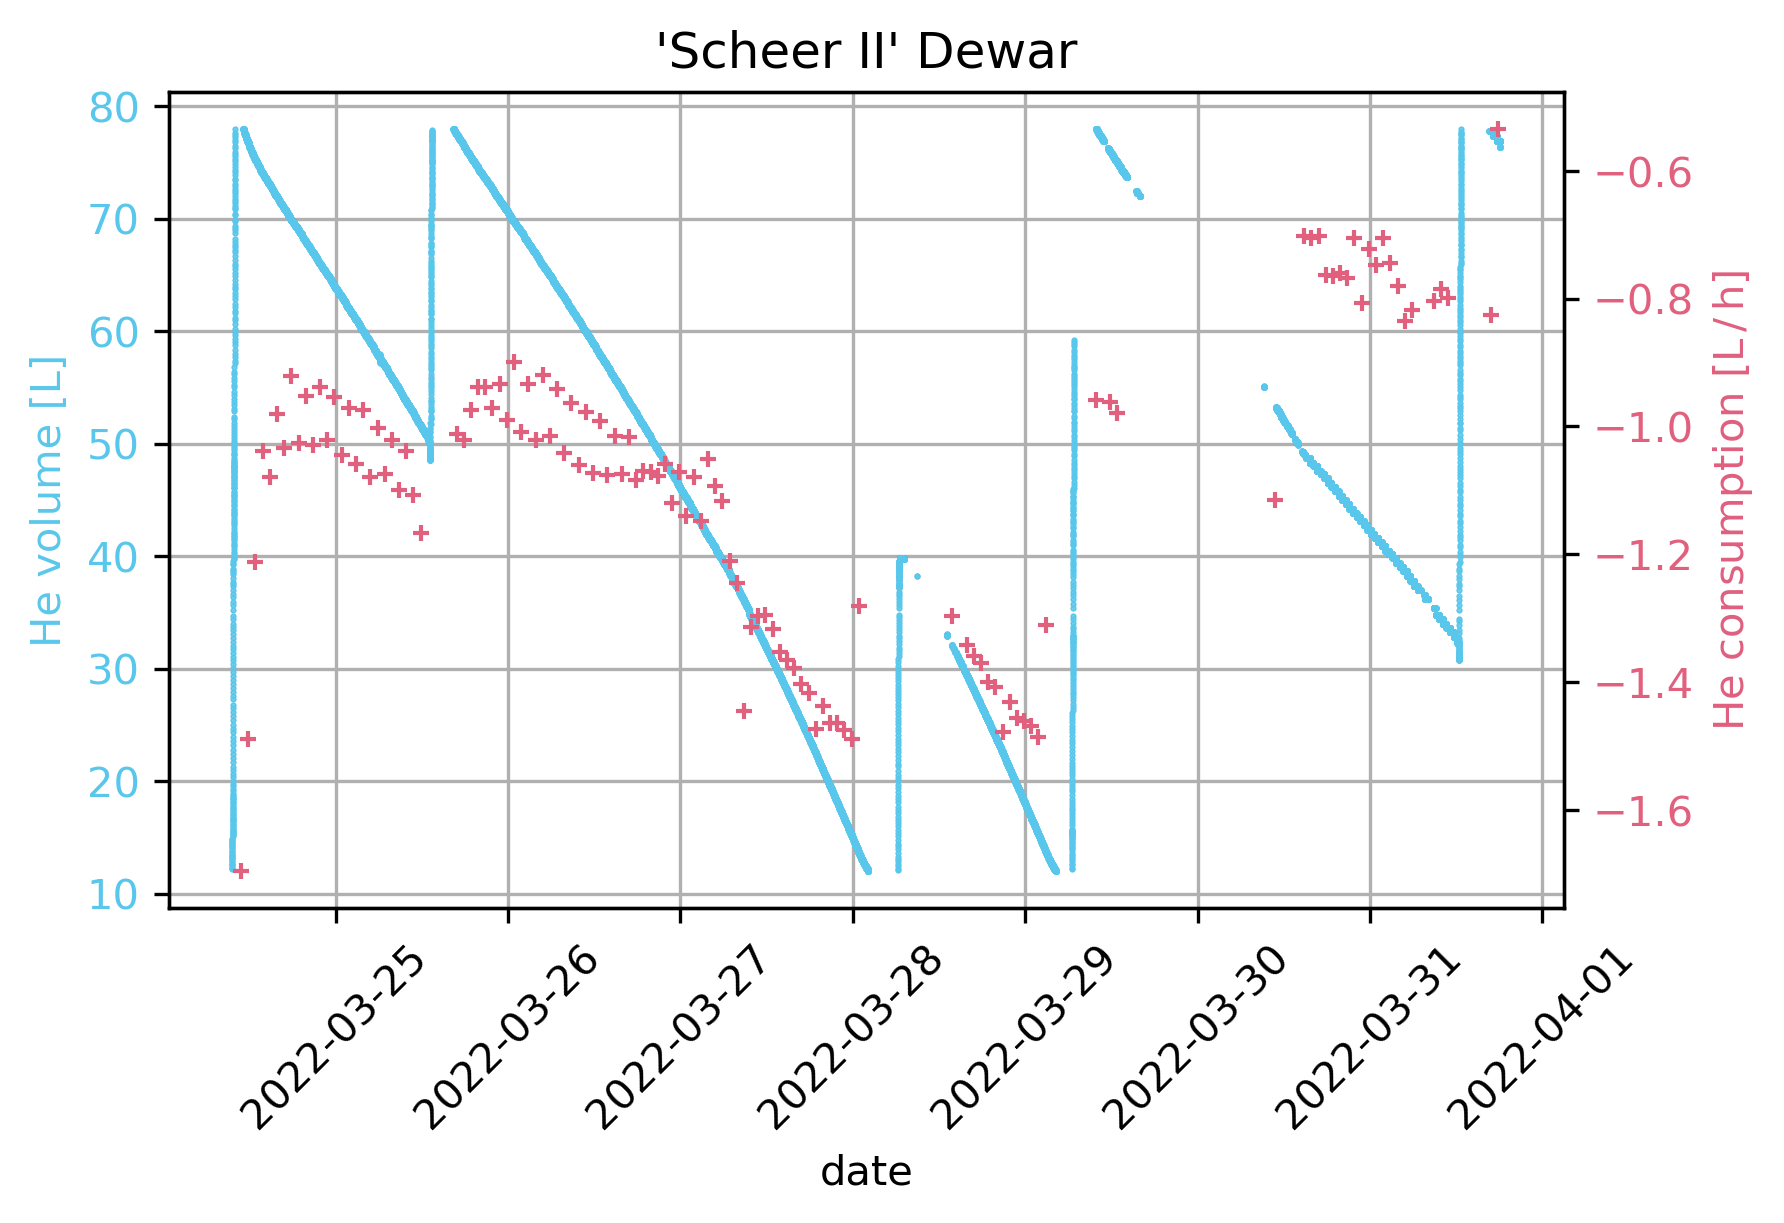

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime

def get_data(path='helium', name='helium', max_days=14):
    files = glob(f"{path}\\{name}_*.csv")[-max_days:]
    data = np.array([0],dtype=[('date','datetime64[s]'), ('fill_height','f8'),
                                   ('volume','f8'), ('percentage','f8')])
    print(files)
    for file in files:
        dat = np.genfromtxt(file, comments='#', delimiter=",", 
                            dtype=[('date','datetime64[s]'), ('fill_height','f8'),
                                   ('volume','f8'), ('percentage','f8')])
        data=np.concatenate((data, dat), axis=0)
    return data[1:]

def get_consumption(data):
    x=np.array(data['date'], dtype='float64')
    y=data['volume']
    y[y<=12]=np.nan
    y[y>=78]=np.nan
    
    nux = np.arange(np.min(x), np.max(x), 600)
    extra_point = 2*nux[-1]-nux[-2]
    bins = np.ones(len(nux)+1)*extra_point
    bins[:-1] = nux
    
    tempx = x[np.logical_not(np.isnan(y))]
    tempy = y[np.logical_not(np.isnan(y))]

    nuy_d = np.histogram(tempx, bins)[0]
    nuy_d = np.array(nuy_d, dtype='float64')
    nuy_d[nuy_d==0] = np.nan
    nuy = (np.histogram(tempx, bins, weights=tempy)[0] / nuy_d)
    
    nudy=np.gradient(nuy)*6
    nudy[nudy>0]=np.nan
    
    nudy = np.convolve(nudy, np.ones(5), 'same') / 5
    nudx = np.arange(np.min(x), np.max(x), 3600)
    extra_point = 2*nudx[-1]-nudx[-2]
    bins = np.ones(len(nudx)+1)*extra_point
    bins[:-1] = nudx

    tempdx = nux[np.logical_not(np.isnan(nudy))]
    tempdy = nudy[np.logical_not(np.isnan(nudy))]

    nudy_d = np.histogram(tempdx, bins)[0]
    nudy_d = np.array(nudy_d, dtype='float64')
    nudy_d[nudy_d==0] = np.nan
    nunudy = (np.histogram(tempdx, bins, weights=tempdy)[0] / nudy_d)
    return np.array(nudx, dtype='datetime64[s]'), nunudy

def generate_plot(args):
    
    if args['max_days'] is not None:
        data = get_data(max_days = args['max_days'])  
    else:
        data = get_data()      
    
    
    x, y = data['date'], data['volume']
    fig, axa = plt.subplots(figsize=(6, 3.6), dpi=300)
    fig.patch.set_facecolor('white')
    
    if args['time'] is not None:
        x_max = np.array(x[-1], dtype='float64')
        x_min = np.array(x[-1], dtype='float64')
        x_min = x_min - np.array(np.timedelta64(int(args['time']*3600),'s'), dtype='float64')
        if args['before'] is not None:
            x_max = x_max - np.array(np.timedelta64(int(args['before']*3600),'s'), dtype='float64')
            x_min = x_min - np.array(np.timedelta64(int(args['before']*3600),'s'), dtype='float64')
        index = [np.abs(np.array(x, dtype='float64')-x_min).argmin(),
                 np.abs(np.array(x, dtype='float64')-x_max).argmin()]
        
        x = x[index[0]:index[1]]
        x = (np.array(x, dtype='float64') - np.array(x[-1], dtype='float64'))/3600
        y = y[index[0]:index[1]]
        
        axa.set_xlabel(f"time till {data['date'][-1]} [h]")
    else:
        x = data['date']
        y = data['volume']
        axa.set_xlabel('date')
        axa.xaxis.set_tick_params(rotation=45)
    
    seeblau = [ 89/255, 199/255, 235/255]
    if args['consumption']:
        axb = axa.twinx()
        (dx, dy) = get_consumption(data)
        if args['time'] is not None:
            dx_max = np.array(dx[-1], dtype='float64')
            dx_min = np.array(dx[-1], dtype='float64')
            dx_min = dx_min - np.array(np.timedelta64(int(args['time']*3600),'s'), dtype='float64')
            if args['before'] is not None:
                dx_max = dx_max - np.array(np.timedelta64(int(args['before']*3600),'s'), dtype='float64')
                dx_min = dx_min - np.array(np.timedelta64(int(args['before']*3600),'s'), dtype='float64')
            dindex = [np.abs(np.array(dx, dtype='float64')-dx_min).argmin(),
                      np.abs(np.array(dx, dtype='float64')-dx_max).argmin()]
            dx = dx[dindex[0]:dindex[1]]
            dx = (np.array(dx, dtype='float64') - np.array(dx[-1], dtype='float64'))/3600
            dy = dy[dindex[0]:dindex[1]]
            
        pinky = [224/255,  96/255, 126/255]
        axa.plot(x,y,'.', ms=1, c=seeblau, label=f"")
        axb.plot(dx,dy,'+',ms=4, c=pinky)
        axa.set_ylabel('He volume [L]', color=seeblau)
        axa.tick_params(axis='y', labelcolor=seeblau)
        axb.set_ylabel(r'He consumption [L$\,$/$\,$h]', color=pinky)
        axb.tick_params(axis='y', labelcolor=pinky)
    else:
        axa.plot(x,y,'.', ms=1, c=seeblau, label=f"")
        axa.set_ylabel('He volume [L]')
        
    y_lim = axa.get_ylim()
    if not args['y_zoom']:
        axa.set_ylim([0, 85])
        
    
    axa.grid()
    
    plt.title("'Scheer II' Dewar")
    
    file_name = '._temp.png'
    plt.savefig(file_name, bbox_inches='tight')
    caption = f"plot generated at {datetime.utcnow()}"
    return file_name, caption
    
'''
# Test
args = plot_arg_handler('')
print(args)
generate_plot(args)
'''
args, dec = plot_arg_handler('y:1 c:1')
generate_plot(args)

{'time': None, 'before': None, 'y_zoom': None, 'max_days': None} /plot arguments, seperated by ' ' and followed by:
h|t|hour|time:24 #h
bf|before:12 #h
md|max_days|maxdays:7 #d
y|yzoom|y_zoom:1|True|0|False
['helium\\helium__2022-03-24.csv', 'helium\\helium__2022-03-25.csv', 'helium\\helium__2022-03-26.csv', 'helium\\helium__2022-03-27.csv', 'helium\\helium__2022-03-28 (2).csv', 'helium\\helium__2022-03-28.csv', 'helium\\helium__2022-03-29.csv', 'helium\\helium__2022-03-30.csv', 'helium\\helium__2022-03-31.csv']
['2022-03-24T07:49:47' '2022-03-24T07:49:52' '2022-03-24T07:49:57' ...
 '2022-03-31T15:54:44' '2022-03-31T15:54:50' '2022-03-31T15:54:55']
['2022-03-24T07:49:47' '2022-03-24T08:49:47' '2022-03-24T09:49:47'
 '2022-03-24T10:49:47' '2022-03-24T11:49:47' '2022-03-24T12:49:47'
 '2022-03-24T13:49:47' '2022-03-24T14:49:47' '2022-03-24T15:49:47'
 '2022-03-24T16:49:47' '2022-03-24T17:49:47' '2022-03-24T18:49:47'
 '2022-03-24T19:49:47' '2022-03-24T20:49:47' '2022-03-24T21:49:47'
 '2022-0

('._temp.png', 'plot generated at 2022-03-31 15:55:01.164774')

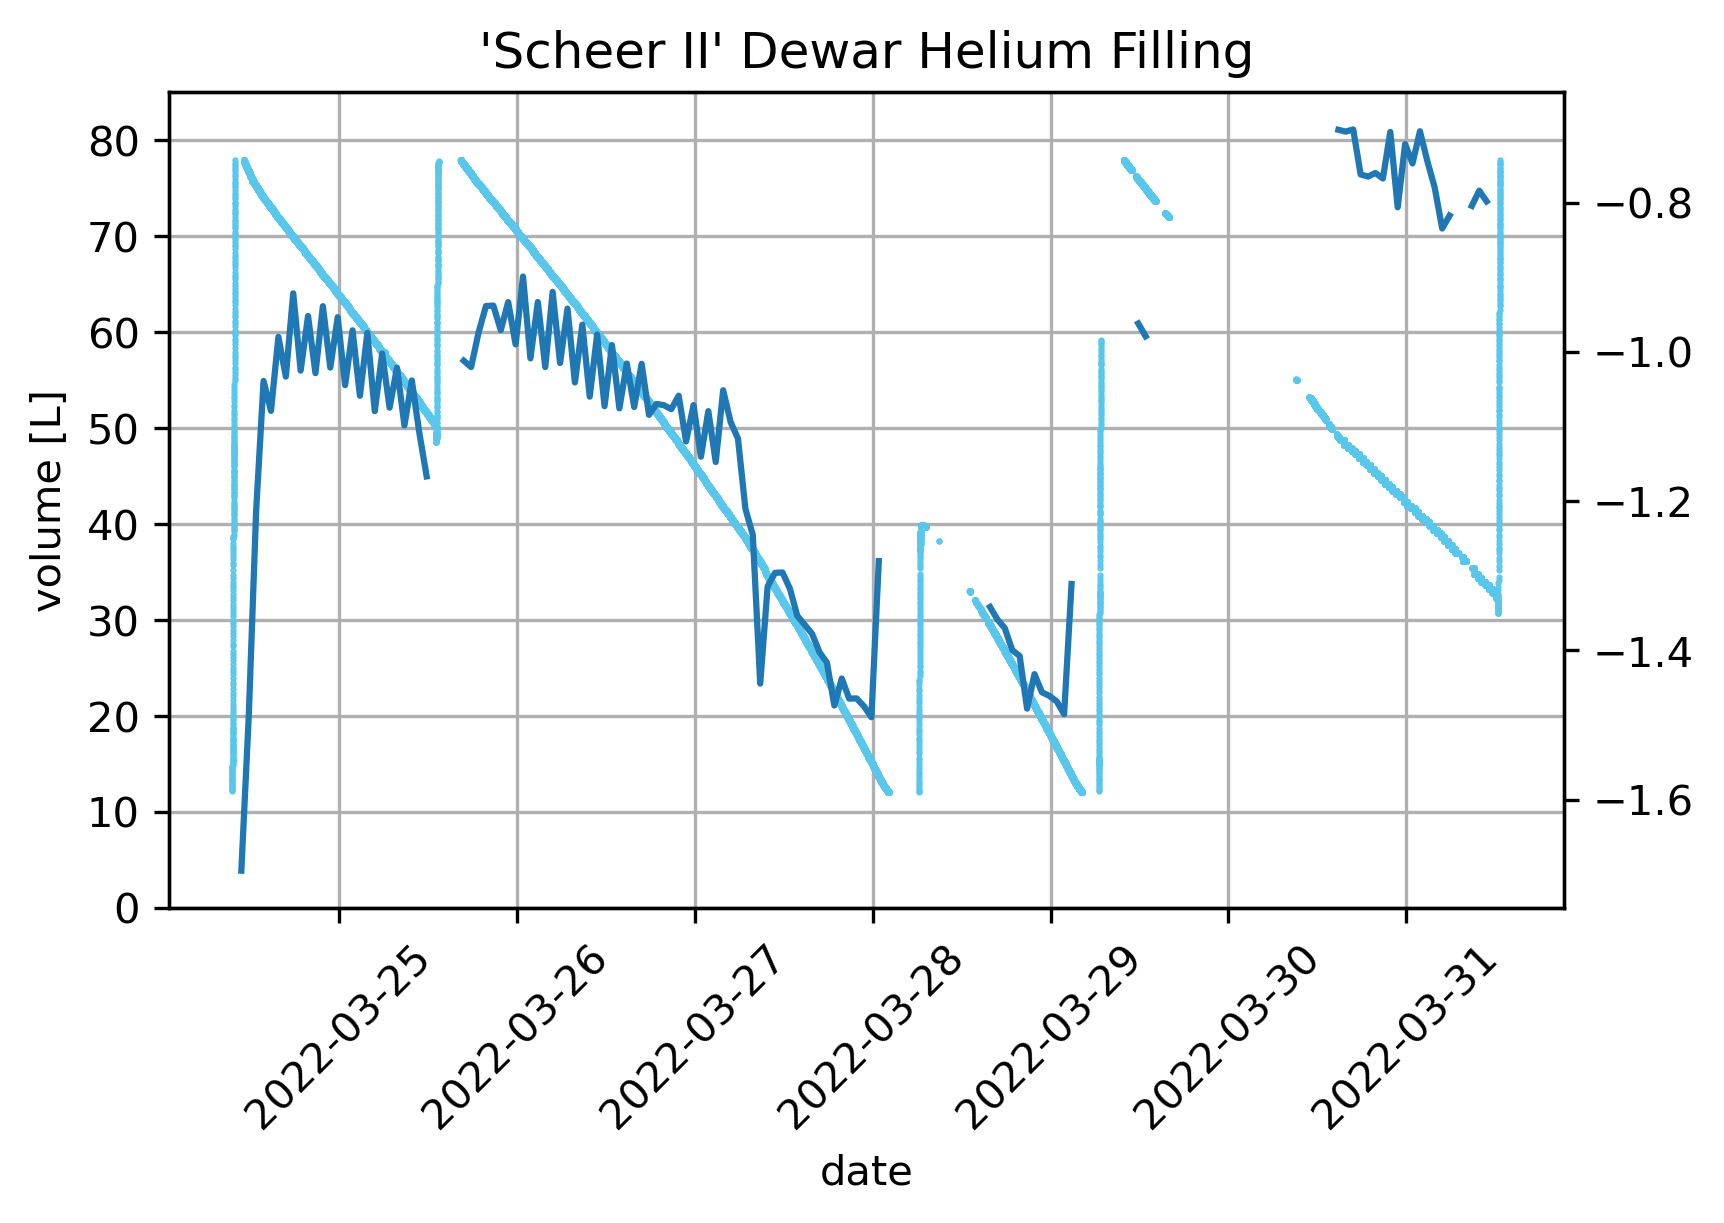

In [373]:

args, decia = plot_arg_handler('')
print(args, decia)
generate_plot(args)

In [359]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime

def get_data(path='helium', name='helium', max_days=14):
    files = glob(f"{path}\\{name}_*.csv")[-max_days:]
    data = np.array([0],dtype=[('date','datetime64[s]'), ('fill_height','f8'),
                                   ('volume','f8'), ('percentage','f8')])
    print(files)
    for file in files:
        dat = np.genfromtxt(file, comments='#', delimiter=",", 
                            dtype=[('date','datetime64[s]'), ('fill_height','f8'),
                                   ('volume','f8'), ('percentage','f8')])
        data=np.concatenate((data, dat), axis=0)
    return data[1:]



def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
data = get_data()
x=np.array(data['date'], dtype='float64')
y=data['volume']
y[y<=12]=np.nan
y[y>=78]=np.nan

['helium\\helium__2022-03-24.csv', 'helium\\helium__2022-03-25.csv', 'helium\\helium__2022-03-26.csv', 'helium\\helium__2022-03-27.csv', 'helium\\helium__2022-03-28 (2).csv', 'helium\\helium__2022-03-28.csv', 'helium\\helium__2022-03-29.csv', 'helium\\helium__2022-03-30.csv', 'helium\\helium__2022-03-31.csv']


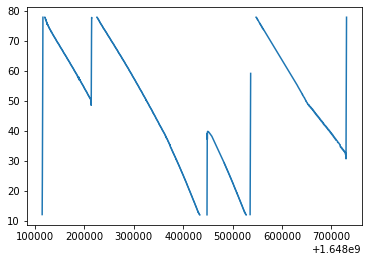

In [318]:
plt.plot(x,y)

In [351]:
nux = np.arange(np.min(x), np.max(x), 600)
extra_point = 2*nux[-1]-nux[-2]
bins = np.ones(len(nux)+1)*extra_point
bins[:-1] = nux

tempx = x[np.logical_not(np.isnan(y))]
tempy = y[np.logical_not(np.isnan(y))]

nuy_d = np.histogram(tempx, bins)[0]
nuy_d = np.array(nuy_d, dtype='float64')
nuy_d[nuy_d==0] = np.nan
nuy = (np.histogram(tempx, bins, weights=tempy)[0] / nuy_d)

In [352]:
nudy=np.gradient(nuy)
nudy[nudy>0]=np.nan

In [353]:
nudy = moving_average(nudy, 5)
nux = nux[2:-2]

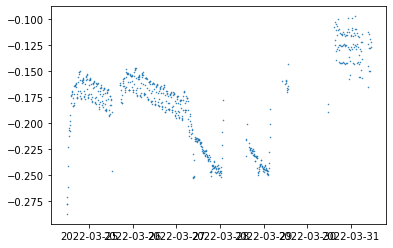

In [354]:

plt.plot(np.array(nux, dtype='datetime64[s]'),nudy,'.', ms=1)

In [357]:
nudx = np.arange(np.min(x), np.max(x), 3600)
extra_point = 2*nudx[-1]-nudx[-2]
bins = np.ones(len(nudx)+1)*extra_point
bins[:-1] = nudx

tempdx = nux[np.logical_not(np.isnan(nudy))]
tempdy = nudy[np.logical_not(np.isnan(nudy))]

nudy_d = np.histogram(tempdx, bins)[0]
nudy_d = np.array(nudy_d, dtype='float64')
nudy_d[nudy_d==0] = np.nan
nunudy = (np.histogram(tempdx, bins, weights=tempdy)[0] / nudy_d)

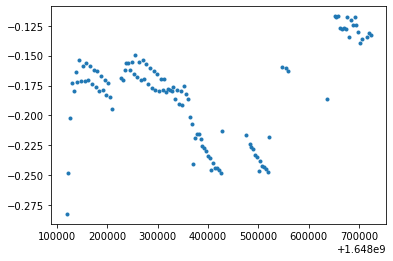

In [358]:

plt.plot(nudx,nunudy,'.')

In [237]:

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w
from scipy.signal import savgol_filter
nuy = moving_average(nuy, 5)
nudy=np.gradient(nuy)
#nudy[nudy>=0]=np.nan
#nudy = moving_average(nudy, 10)
np.shape(nux), np.shape(tempx), np.shape(x), np.shape(dx)

((1044,), (85887,), (95922,), (125152,))

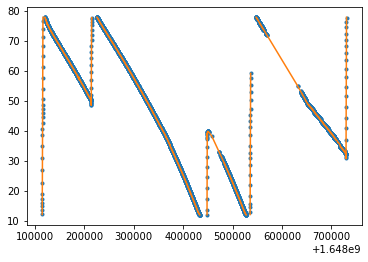

In [246]:
#plt.plot(nux,nuy)
plt.plot(nux,nuy,'.')
plt.plot(x,y)

In [239]:

# Import and initialize Driver
from AMI135 import AMI135
ami135 = AMI135()

2022-03-31 17:04:44,132 - root - INFO - (AMI135) ... initialized!


In [12]:

# Import and initialize Driver
ami135 = AMI135()
ami135.status

2022-03-31 10:44:32,031 - root - INFO - (AMI135) ... initialized!


{'utc_timer': datetime.datetime(2022, 3, 31, 8, 44, 32, 32527),
 'fill_heigth': 60.6,
 'volume': 35.413636363636364,
 'ratio': 44.82738780207134,
 'string': '2022-03-31 08:44:32, 60.6, 35.413636363636364, 44.82738780207134',
 'printer': '2022-03-31 08:44:32, 60.6 cm, 35.41 L, 44.83 %'}

In [15]:
from threading import Thread, Event
from datetime import timedelta, datetime
from logging import getLogger
from time import sleep

# Import and configurate Logger
from logging import getLogger, basicConfig, INFO
logger = getLogger()    
basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                     level=INFO)

class LevelMeterWorker(Thread):
    def __init__(self,
                 driver):
        super().__init__()
        self.exit_request = Event()
        self.name = f"LevelMeterWorker"
        
        self.driver = driver
        self.refresh_rate = 2 #s        
        self.status = self.driver.status
        logger.info(f"({self.name}) ... initialized!")
        
    def run(self):
        logger.info(f"({self.name}) ... started running!")
        temp_notification_timer = datetime.utcnow()
        while not self.exit_request.is_set():
            timer = datetime.utcnow()
            if (timer - temp_notification_timer) >= timedelta(seconds=self.refresh_rate):
                temp_notification_timer=timer
                self.status = self.driver.status
                logger.debug(f"({self.name}) {self.status['printer']}")
            sleep(.1)
        logger.info(f"({self.name}) ... stopped running!")
        
levelmeterworker = LevelMeterWorker(driver=ami135)
levelmeterworker.start()
sleep(5)
levelmeterworker.exit_request.set()

2022-03-31 10:45:37,118 - root - INFO - (LevelMeterWorker) ... initialized!
2022-03-31 10:45:37,120 - root - INFO - (LevelMeterWorker) ... started running!
2022-03-31 10:45:39,197 - root - INFO - (LevelMeterWorker) 2022-03-31 08:45:39, 60.6 cm, 35.41 L, 44.83 %
2022-03-31 10:45:41,254 - root - INFO - (LevelMeterWorker) 2022-03-31 08:45:41, 60.6 cm, 35.41 L, 44.83 %
2022-03-31 10:45:42,138 - root - INFO - (LevelMeterWorker) ... stopped running!


In [4]:

levelmeterworker.exit_request.set()

2022-03-31 10:36:22,266 - root - INFO - (LevelMeterWorker) ... stopped running!


In [21]:
class LevelMeter:
    def __init__(self, driver):
        self.name = f"LevelMeter"
        self.driver = driver
        self.levelmeterworker = LevelMeterWorker(driver)
        logger.info(f"({self.name}) ... initialized!")
    def start(self):
        self.levelmeterworker.start()
        logger.info(f"({self.name}) Worker is started.")
    def close(self):
        self.levelmeterworker.exit_request.set()
        logger.info(f"({self.name}) Worker is stopped.")
    @property
    def status(self):
        return self.levelmeterworker.status
levelmeter = LevelMeter(driver=ami135)
levelmeter.start()
        

2022-03-31 10:48:02,384 - root - INFO - (LevelMeterWorker) ... initialized!
2022-03-31 10:48:02,386 - root - INFO - (LevelMeter) ... initialized!
2022-03-31 10:48:02,388 - root - INFO - (LevelMeterWorker) ... started running!
2022-03-31 10:48:02,390 - root - INFO - (LevelMeter) Worker is started.
2022-03-31 10:48:04,455 - root - INFO - (LevelMeterWorker) 2022-03-31 08:48:04, 60.6 cm, 35.41 L, 44.83 %
2022-03-31 10:48:06,545 - root - INFO - (LevelMeterWorker) 2022-03-31 08:48:06, 60.6 cm, 35.41 L, 44.83 %


In [22]:
levelmeter.status

{'utc_timer': datetime.datetime(2022, 3, 31, 8, 48, 6, 525457),
 'fill_heigth': 60.6,
 'volume': 35.413636363636364,
 'ratio': 44.82738780207134,
 'string': '2022-03-31 08:48:06, 60.6, 35.413636363636364, 44.82738780207134',
 'printer': '2022-03-31 08:48:06, 60.6 cm, 35.41 L, 44.83 %'}

2022-03-31 10:48:08,649 - root - INFO - (LevelMeterWorker) 2022-03-31 08:48:08, 60.6 cm, 35.41 L, 44.83 %


In [23]:
levelmeter.close()

2022-03-31 10:48:09,667 - root - INFO - (LevelMeter) Worker is stopped.
2022-03-31 10:48:09,722 - root - INFO - (LevelMeterWorker) ... stopped running!


In [15]:
from threading import Thread, Event
from datetime import timedelta, datetime
from logging import getLogger
from telegram.ext import Updater
from AMI135 import AMI135
from time import sleep

logger = getLogger()

class NotificationsWorker(Thread):
    def __init__(self,
                ami135,
                updater,
                chat_id):
        super().__init__()
        self.exit_request = Event()
        self.notifications = Event()
        self.alarm = Event()
        self.name = f"NotificationsWorker[{chat_id}]"
        
        self.ami135 = ami135
        self.updater = updater
        self.chat_id = chat_id
        
        self.refresh_rate = 3600. #s
        self.alarm_level = 20. #L
        self.program_refresh = 2. #s
        
        logger.info(f"({self.name}) ... initialized!")
        
    def run(self):
        logger.info(f"({self.name}) ... started running!")
        temp_notification_timer = datetime.utcnow() - timedelta(seconds=self.refresh_rate+1)
        while self.notifications.is_set():
            timer = datetime.utcnow()
            if (timer - temp_notification_timer) >= timedelta(seconds=self.refresh_rate):
                temp_notification_timer=timer
                timeout=False
                while not timeout:
                    try:
                        status = self.ami135.status
                    except:
                        timeout = True

                if self.alarm.is_set() and status['liters'] <= self.alarm_level:
                    disable_notification = False
                else:
                    disable_notification = True

                self.updater.bot.send_message(chat_id=self.chat_id,
                                              text=f"{status['printer']}",
                                              disable_notification=disable_notification)
                logger.info(f"({self.name}) {status['printer']}")

            sleep(self.program_refresh)
        logger.info(f"({self.name}) ... stopped running!")
'''
# Test
notificationworker = NotificationsWorker(ami135=ami135,
                                        updater=updater,
                                        chat_id=62579439)

notificationworker.notifications.set()
notificationworker.start()
notificationworker.refresh_rate = 3
'''

class Notifications():
    def __init__(self, ami135, updater):
        self.name = 'Notifications'
        self.ami135 = ami135
        self.updater = updater
        self.chat_ids = []
        self.notificationworker = {}
        logger.info(f"({self.name}) ... initialized!")
        
    def close_all(self):
        for chat_id in self.chat_ids:
            self.set_notifications(chat_id, value=False)
            
    @property
    def threads(self):
        return self.chat_ids, self.notificationworker
    
    @property
    def status(self):
        status=[]
        for chat_id in self.chat_ids:
            status.append(self.get_status(chat_id))
        return status
    
    def get_status(self, chat_id):
        status = {
            "chat_id": chat_id,
            "notifications": self.get_notifications(chat_id),
            "alarm": self.get_alarm(chat_id),
            "refresh_rate": self.get_refresh_rate(chat_id),
            "level": self.get_alarm_level(chat_id),
            "program_refresh": self.get_program_refresh(chat_id),
            }
        return status        
                  
    def get_notifications(self, chat_id) -> bool:
        return self.notificationworker[f"{chat_id}"].notifications.is_set()
    def set_notifications(self, chat_id, value:bool):
        if value:
            if not chat_id in self.chat_ids:
                self.chat_ids.append(chat_id)
                self.notificationworker[f"{chat_id}"] = NotificationsWorker(self.ami135,
                                                                            self.updater,
                                                                            chat_id)
                self.notificationworker[f"{chat_id}"].notifications.set()
                self.notificationworker[f"{chat_id}"].start()
                logger.info(f"({self.name})[{chat_id}] Worker is started.")
            else:
                self.notificationworker[f"{chat_id}"].notifications.set()
        elif not value:
            self.notificationworker[f"{chat_id}"].notifications.clear()
            while not self.notificationworker[f"{chat_id}"].exit_request.is_set():
                self.notificationworker[f"{chat_id}"].exit_request.set()
                sleep(.1)
            self.chat_ids.remove(chat_id)
            logger.info(f"({self.name})[{chat_id}] Worker is closed.")
        else:
            pass
                  
    def get_alarm(self, chat_id) -> bool:
        return self.notificationworker[f"{chat_id}"].alarm.is_set()
    def set_alarm(self, chat_id, value:bool):
        if value:
            self.notificationworker[f"{chat_id}"].alarm.set()
        else:
            self.notificationworker[f"{chat_id}"].alarm.clear()
    
    def get_refresh_rate(self, chat_id) -> float:
        return self.notificationworker[f"{chat_id}"].refresh_rate
    def set_refresh_rate(self, chat_id, value: float):
        self.notificationworker[f"{chat_id}"].refresh_rate = value
        
    def get_alarm_level(self, chat_id) -> float:
        return self.notificationworker[f"{chat_id}"].alarm_level
    def set_alarm_level(self, chat_id, value: float):
        self.notificationworker[f"{chat_id}"].alarm_level = value
        
    def get_program_refresh(self, chat_id) -> float:
        return self.notificationworker[f"{chat_id}"].program_refresh
    def set_program_refresh(self, chat_id, value: float):
        self.notificationworker[f"{chat_id}"].program_refresh = value
        
'''
# Test
notifications = Notifications(ami135=ami135, updater=updater)
notifications.set_notifications(chat_id=62579439, value=True)
notifications.set_notifications(chat_id=-771946321, value=True)
notifications.set_refresh_rate(chat_id=62579439, value=10)
notifications.set_refresh_rate(chat_id=-771946321, value=10)
print(notifications.status, notifications.threads)
notifications.close_all()
'''

'\n# Test\nnotifications = Notifications(ami135=ami135, updater=updater)\nnotifications.init(chat_id=62579439)\nnotifications.init(chat_id=-771946321)\nnotifications.set_refresh_rate(chat_id=62579439, value=10)\nnotifications.set_refresh_rate(chat_id=-771946321, value=10)\nprint(notifications.get_status(chat_id=62579439),\n    notifications.get_status(chat_id=-771946321))\n'

In [16]:
# Import and configurate Logger
from logging import getLogger, basicConfig, INFO
logger = getLogger()    
basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                     level=INFO)

# Import and initialize Telegram Bot
from telegram import Update
from telegram.ext import Updater, CommandHandler, CallbackContext, MessageHandler, Filters
schmampfpy3_token = '1817796104:AAE-PugEYnIUzDh4tR1hjz86cfs9Ooz_gLc'
updater = Updater(token=schmampfpy3_token, use_context=True)

# Import and initialize Driver
from AMI135 import AMI135
ami135 = AMI135()

notifications = Notifications(ami135=ami135, updater=updater)
notifications.set_notifications(chat_id=62579439, value=True)
notifications.set_notifications(chat_id=-771946321, value=True)

2022-03-31 09:26:47,391 - root - INFO - (AMI135) ... initialized!
2022-03-31 09:26:47,393 - root - INFO - (Notifications) ... initialized!
2022-03-31 09:26:47,393 - root - INFO - (NotificationsWorker[62579439]) ... initialized!
2022-03-31 09:26:47,395 - root - INFO - (NotificationsWorker[62579439]) ... started running!
2022-03-31 09:26:47,397 - root - INFO - (Notifications)[62579439] Worker is started.
2022-03-31 09:26:47,400 - root - INFO - (NotificationsWorker[-771946321]) ... initialized!
2022-03-31 09:26:47,401 - root - INFO - (NotificationsWorker[-771946321]) ... started running!
2022-03-31 09:26:47,406 - root - INFO - (Notifications)[-771946321] Worker is started.


In [17]:

notifications.set_refresh_rate(chat_id=62579439, value=10)
notifications.set_refresh_rate(chat_id=-771946321, value=100)

In [24]:
notifications.status, notifications.threads

([{'chat_id': -771946321,
   'notifications': True,
   'alarm': False,
   'refresh_rate': 100,
   'level': 20.0,
   'program_refresh': 2.0},
  {'chat_id': 62579439,
   'notifications': True,
   'alarm': False,
   'refresh_rate': 3600.0,
   'level': 20.0,
   'program_refresh': 2.0}],
 ([-771946321, 62579439],
  {'62579439': <NotificationsWorker(NotificationsWorker[62579439], started 12876)>,
   '-771946321': <NotificationsWorker(NotificationsWorker[-771946321], started 2616)>}))

In [25]:
notifications.close_all()

2022-03-31 09:30:23,109 - root - INFO - (Notifications)[-771946321] Worker is closed.
2022-03-31 09:30:45,302 - root - INFO - (NotificationsWorker[62579439]) 2022-03-31 07:30:35, 63.6 cm, 36.57 L, 46.29 %
2022-03-31 09:30:45,516 - root - INFO - (NotificationsWorker[-771946321]) 2022-03-31 07:30:35, 63.6 cm, 36.57 L, 46.29 %
2022-03-31 09:30:47,529 - root - INFO - (NotificationsWorker[-771946321]) ... stopped running!


In [23]:

notifications.set_notifications(chat_id=62579439, value=True)

2022-03-31 09:30:04,499 - root - INFO - (NotificationsWorker[62579439]) ... initialized!
2022-03-31 09:30:04,501 - root - INFO - (NotificationsWorker[62579439]) ... started running!
2022-03-31 09:30:04,506 - root - INFO - (Notifications)[62579439] Worker is started.


In [7]:
notifications.threads

([62579439, -771946321],
 {'62579439': <NotificationsWorker(NotificationsWorker[62579439], started 7996)>,
  '-771946321': <NotificationsWorker(NotificationsWorker[-771946321], started 7632)>})

In [11]:
from threading import Thread, Event
from datetime import timedelta, datetime
from logging import getLogger
from telegram.ext import Updater
from AMI135 import AMI135
from time import sleep

logger = getLogger()

class NotificationsWorker(Thread):
    def __init__(self,
                ami135,
                updater,
                chat_id):
        super().__init__()
        self.exit_request = Event()
        self.notifications = Event()
        self.alarm = Event()
        self.name = f"NotificationsWorker[{chat_id}]"
        
        self.ami135 = ami135
        self.updater = updater
        self.chat_id = chat_id
        
        self.refresh_rate = 3600. #s
        self.alarm_level = 20. #L
        self.program_refresh = 2. #s
        
        logger.info(f"({self.name}) ... initialized!")
        
    def run(self):
        logger.info(f"({self.name}) ... started running!")
        temp_notification_timer = datetime.utcnow() - timedelta(seconds=self.refresh_rate+1)
        while not self.exit_request.is_set():
            while self.notifications.is_set():
                timer = datetime.utcnow()
                if (timer - temp_notification_timer) >= timedelta(seconds=self.refresh_rate):
                    temp_notification_timer=timer
                    timeout=False
                    while not timeout:
                        try:
                            status = self.ami135.status
                        except:
                            timeout = True
                    
                    if self.alarm.is_set() and status['liters'] <= self.alarm_level:
                        disable_notification = False
                    else:
                        disable_notification = True
                        
                    self.updater.bot.send_message(chat_id=self.chat_id,
                                                  text=f"{status['printer']}",
                                                  disable_notification=disable_notification)
                    logger.info(f"({self.name}) {status['printer']}")
                    
                sleep(self.program_refresh)
            sleep(self.program_refresh)
        logger.info(f"({self.name}) ... stopped running!")
'''
# Test
notificationworker = NotificationsWorker(ami135=ami135,
                                        updater=updater,
                                        chat_id=62579439)

notificationworker.start()
notificationworker.notifications.set()
notificationworker.refresh_rate = 3
'''
notificationworker = NotificationsWorker(ami135=ami135,
                                        updater=updater,
                                        chat_id=62579439)

notificationworker.start()
notificationworker.notifications.set()
notificationworker.refresh_rate = 10

2022-03-30 16:53:25,368 - root - INFO - (NotificationsWorker[62579439]) ... initialized!
2022-03-30 16:53:25,371 - root - INFO - (NotificationsWorker[62579439]) ... started running!
2022-03-30 16:53:29,791 - root - INFO - (HeliumLoggerWorker) ... driver timeout!
2022-03-30 16:53:34,738 - root - INFO - (NotificationsWorker[62579439]) 2022-03-30 14:53:24, 81.0 cm, 48.96 L, 61.98 %
2022-03-30 16:53:41,762 - root - INFO - (NotificationsWorker[62579439]) 2022-03-30 14:53:31, 81.0 cm, 48.96 L, 61.98 %
2022-03-30 16:53:46,839 - root - INFO - (NotificationsWorker[62579439]) 2022-03-30 14:53:24, 81.0 cm, 48.96 L, 61.98 %
2022-03-30 16:54:01,893 - root - INFO - (NotificationsWorker[62579439]) 2022-03-30 14:53:51, 81.0 cm, 48.96 L, 61.98 %
2022-03-30 16:54:02,569 - root - INFO - (NotificationsWorker[62579439]) 2022-03-30 14:53:52, 81.0 cm, 48.96 L, 61.98 %
2022-03-30 16:54:15,034 - root - INFO - (NotificationsWorker[62579439]) 2022-03-30 14:54:04, 81.0 cm, 48.96 L, 61.98 %
2022-03-30 16:54:17,263

In [1]:

# Import and initialize Driver
from AMI135 import AMI135
ami135 = AMI135()

# Import and initialize HeliumLogger, with Driver as Input
from HeliumLogger import HeliumLogger
heliumlogger = HeliumLogger(ami135=ami135)

# Import and initialize Telegram Bot
from telegram import Update
from telegram.ext import Updater, CommandHandler, CallbackContext, MessageHandler, Filters
schmampfpy3_token = '1817796104:AAE-PugEYnIUzDh4tR1hjz86cfs9Ooz_gLc'
updater = Updater(token=schmampfpy3_token, use_context=True)
dispatcher = updater.dispatcher
telegram_bot = "TelegramBot"
all_commands={'help':['help','hlep']}


'\n# Test\nnotificationworker = NotificationsWorker(ami135=ami135,\n                                        updater=updater,\n                                        chat_id=62579439)\n\nnotificationworker.start()\nnotificationworker.notifications.set()\nnotificationworker.refresh_rate = 3\n'

'\n# Test\nnotifications = Notifications(ami135=ami135, updater=updater)\nnotifications.init(chat_id=62579439)\nnotifications.init(chat_id=-771946321)\nnotifications.set_refresh_rate(chat_id=62579439, value=10)\nnotifications.set_refresh_rate(chat_id=-771946321, value=10)\n'

In [16]:
notifications = Notifications(ami135=ami135, updater=updater)

In [17]:
notifications.init(chat_id=62579439)
notifications.init(chat_id=-771946321)

In [18]:
notifications.set_refresh_rate(chat_id=62579439, value=10)
notifications.set_refresh_rate(chat_id=-771946321, value=100)

In [19]:

print(notifications.get_status(chat_id=62579439),
notifications.get_status(chat_id=-771946321))

({'chat_id': 62579439,
  'notifications': True,
  'alarm': False,
  'refresh_rate': 10,
  'alarm_level': 20.0,
  'program_refresh': 2.0},
 {'chat_id': -771946321,
  'notifications': True,
  'alarm': False,
  'refresh_rate': 100,
  'alarm_level': 20.0,
  'program_refresh': 2.0})